In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

## norm_num = quantity you want to balance classes to 

In [2]:
norm_num = 308

dir_path = 'ct_classifier/data/allclass'
dest_dir = 'ct_classifier/data/allclass/balanced'

train_json = os.path.join(dir_path, 'train/train.json')
val_json = os.path.join(dir_path, 'val/val.json')

In [3]:
with open('ct_classifier/data/allclass/val/annotations.json', 'r') as f:
    val_annot_json = json.load(f)
with open('ct_classifier/data/allclass/val/images.json', 'r') as f:
    val_image_json = json.load(f)
with open('ct_classifier/data/allclass/train/annotations.json', 'r') as f:
    train_annot_json = json.load(f)
with open('ct_classifier/data/allclass/train/images.json', 'r') as f:
    train_image_json = json.load(f)

In [4]:
val_annot_df = pd.DataFrame(val_annot_json)
val_counts = val_annot_df['category_id'].value_counts().reset_index().sort_values('category_id')
train_annot_df = pd.DataFrame(train_annot_json)
train_counts = train_annot_df['category_id'].value_counts().reset_index().sort_values('category_id')

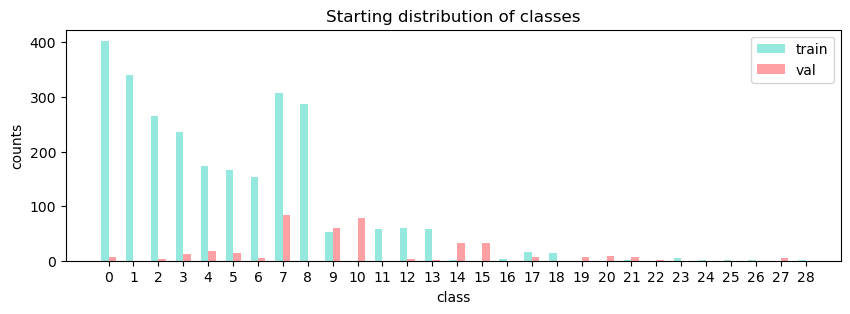

In [5]:
width = 0.3 

plt.figure(figsize=(10,3))
plt.bar(train_counts['category_id']- width/2,train_counts['count'], width=0.3, label='train', color='#95e8dd')
plt.bar(val_counts['category_id']+ width/2,val_counts['count'], width=0.3, label='val', color='#ffa0a5')
plt.xlabel('class')
plt.xticks(range(29),range(29))
plt.ylabel('counts')
plt.title('Starting distribution of classes')
plt.legend()

In [6]:
val_list = val_annot_df['category_id'].to_list()
train_list = train_annot_df['category_id'].to_list()
del_classes = set([x for x in val_list if x not in train_list])

val_annot_df = val_annot_df[~val_annot_df['category_id'].isin(del_classes)]
val_counts = val_annot_df['category_id'].value_counts().reset_index().sort_values('category_id')


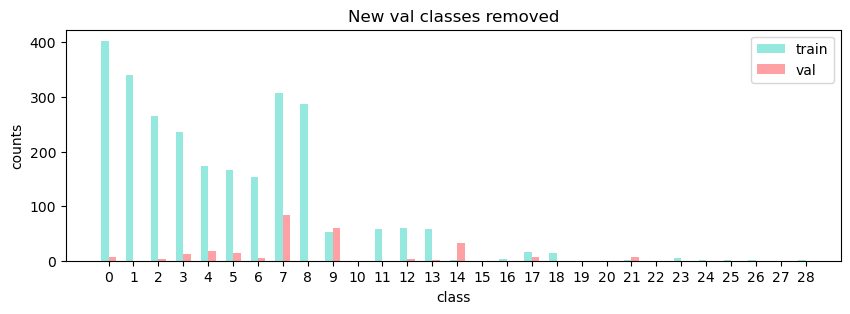

In [7]:
width = 0.3 

plt.figure(figsize=(10,3))
plt.bar(train_counts['category_id']- width/2,train_counts['count'], width=0.3, label='train', color='#95e8dd')
plt.bar(val_counts['category_id']+ width/2,val_counts['count'], width=0.3, label='val', color='#ffa0a5')
plt.xlabel('class')
plt.xticks(range(29),range(29))
plt.ylabel('counts')
plt.title('New val classes removed')
plt.legend()

In [8]:
train_annot_df

,id,image_id,category_id,is_crowd,segmentation,area
0,0,0,6,0,[],3538
1,1,1,6,0,[],1280
2,2,2,6,0,[],1296
3,3,3,6,0,[],2583
4,4,4,0,0,[],14231
...,...,...,...,...,...,...
2604,2604,2604,0,0,[],15264
2605,2605,2605,7,0,[],16820
2606,2606,2606,0,0,[],16224
2607,2607,2607,7,0,[],17136


In [9]:
train_counts['delta'] = norm_num - train_counts['count'] 
train_counts

,category_id,count,delta
0,0,403,-95
1,1,341,-33
4,2,265,43
5,3,235,73
6,4,173,135
7,5,167,141
8,6,154,154
2,7,308,0
3,8,287,21
12,9,52,256


In [10]:
def get_balanced_list(df, df_counts, norm_num):
    files_to_copy = []
    class_df = df.copy()
    df_counts['delta'] = norm_num - df_counts['count'] 

    for index, row in df_counts.iterrows():
        if (row['delta'] > 0) & (row['count'] > row['delta']):
            sample = int(row['delta'])
            sub_df = class_df[class_df['category_id'] == row['category_id']]['image_id']
            class_file_list = sub_df.to_list()
            subsampled_file_list = sub_df.sample(n=sample).to_list()
            class_file_list += subsampled_file_list
            files_to_copy += class_file_list
        elif (row['delta'] > 0) & (row['count'] < row['delta']):
            sub_df = class_df[class_df['category_id'] == row['category_id']]['image_id']
            class_file_list = sub_df.to_list()
            multiplier = int(np.round(row['delta']/row['count']))
            class_file_list += class_file_list*multiplier
            files_to_copy += class_file_list
        elif row['delta'] < 0:
            sub_df = class_df[class_df['category_id'] == row['category_id']]['image_id']
            subsampled_file_list = sub_df.sample(n=norm_num).to_list()
            files_to_copy += subsampled_file_list

    return sorted(files_to_copy)


In [11]:
ids = get_balanced_list(train_annot_df, train_counts, norm_num)
df_ids = pd.DataFrame(ids, columns=['image_id'])
expanded_df = df_ids.merge(train_annot_df, on='image_id', how='left')
train_counts = expanded_df['category_id'].value_counts().reset_index().sort_values('category_id')

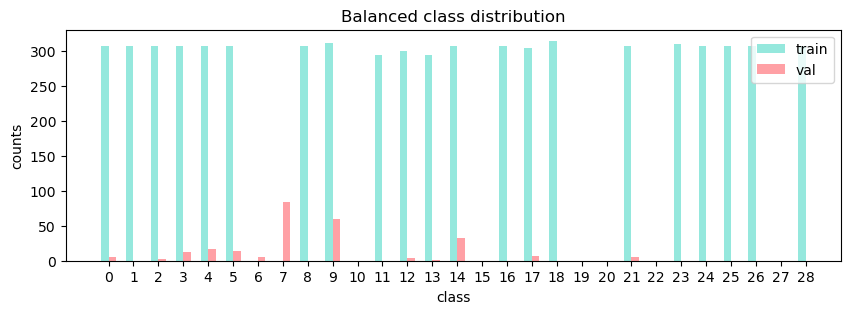

In [13]:
width = 0.3 

plt.figure(figsize=(10,3))
plt.bar(train_counts['category_id']- width/2,train_counts['count'], width=0.3, label='train', color='#95e8dd')
plt.bar(val_counts['category_id']+ width/2,val_counts['count'], width=0.3, label='val', color='#ffa0a5')
plt.xlabel('class')
plt.xticks(range(29),range(29))
plt.ylabel('counts')
plt.title('Balanced class distribution')
plt.legend()

In [14]:
train_annot_df

,id,image_id,category_id,is_crowd,segmentation,area
0,0,0,6,0,[],3538
1,1,1,6,0,[],1280
2,2,2,6,0,[],1296
3,3,3,6,0,[],2583
4,4,4,0,0,[],14231
...,...,...,...,...,...,...
2604,2604,2604,0,0,[],15264
2605,2605,2605,7,0,[],16820
2606,2606,2606,0,0,[],16224
2607,2607,2607,7,0,[],17136


In [24]:
expanded_df = df_ids.merge(train_annot_df.drop(columns='id'), on='image_id', how='left')
expanded_df = expanded_df.reset_index().rename(columns={'index': 'id'})
expanded_df['id'] +=1

In [25]:
expanded_df

,id,image_id,category_id,is_crowd,segmentation,area
0,1,4,0,0,[],14231
1,2,5,11,0,[],20250
2,3,5,11,0,[],20250
3,4,5,11,0,[],20250
4,5,5,11,0,[],20250
...,...,...,...,...,...,...
6438,6439,2597,0,0,[],13632
6439,6440,2599,0,0,[],13724
6440,6441,2601,0,0,[],15912
6441,6442,2606,0,0,[],16224


In [27]:
new_annot_json = json.loads(expanded_df.to_json(orient = 'records'))

In [33]:
with open('ct_classifier/data/allclass/train/train.json', 'r') as f:
    json_out = json.load(f)

json_out['annotations'] = new_annot_json

with open('ct_classifier/data/allclass/train/train_balanced.json', 'w') as f:
    json.dump(json_out, f)